# **SENS PIPELINE FOR FMRI ANALYSIS**

## Import Libraries and Packages

Importing all the necessary OS, shell scripting and imaging operations:

In [66]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import os
from os.path import join, dirname, abspath, isfile, isdir, split, splitext, exists, basename
import sys
import subprocess
import re
import glob
import argparse
import shutil
import json
import nibabel as nib
from nilearn import plotting
from nilearn.image import load_img, mean_img, new_img_like, resample_to_img, threshold_img, high_variance_confounds
from nilearn import datasets
from nilearn import maskers
from nilearn import signal
from nipype.interfaces.fsl.utils import ImageMeants, MotionOutliers
from nilearn.glm.first_level import FirstLevelModel
from nilearn.interfaces.fsl import get_design_from_fslmat
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nilearn.plotting import plot_stat_map, plot_glass_brain, plot_epi, plot_contrast_matrix, plot_img_on_surf
from nilearn.plotting import plot_design_matrix, plot_anat, plot_img, plot_roi


In [9]:
%env

{'ANTSDIR': '/Users/vogt_lab/Library/install',
 'COMMAND_MODE': 'unix2003',
 'CONDA_EXE': '/Users/vogt_lab/opt/anaconda3/bin/conda',
 'CONDA_PYTHON_EXE': '/Users/vogt_lab/opt/anaconda3/bin/python',
 'CONDA_SHLVL': '0',
 'DISPLAY': '/private/tmp/com.apple.launchd.VDV3w6MbVM/org.xquartz:0',
 'FSLDIR': '/Users/vogt_lab/fsl',
 'FSLMULTIFILEQUIT': 'TRUE',
 'FSLOUTPUTTYPE': 'NIFTI_GZ',
 'FSLTCLSH': '/Users/vogt_lab/fsl/bin/fsltclsh',
 'FSLWISH': '/Users/vogt_lab/fsl/bin/fslwish',
 'FSL_LOAD_NIFTI_EXTENSIONS': '0',
 'FSL_SKIP_GLOBAL': '0',
 'HOME': '/Users/vogt_lab',
 'LOGNAME': 'muh',
 'LaunchInstanceID': 'A1F159E8-2D2A-4BF8-8B53-6D898A129D5A',
 'MATLAB_PATH': '/Applications/MATLAB_R2023a.app/bin',
 'MallocNanoZone': '0',
 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined',
 'PATH': '/usr/local/bin:/Users/vogt_lab/Library/Python/3.12/bin:/Users/vogt_lab/Library/Application Support/cloud-code/installer/google-cloud-sdk/bin:/Library/Frameworks/Python.framework/Versions/3.12/bin:/Users/vogt_lab/c3d/Co

## First Level Data Preparation for Preprocessing, and Stats Analyses

**1. DICOM to BIDS conversion** : Run this script for DICOM to BIDS conversion; the configuration file for the dcm2bids call is stored in **/SENS_BIDS/code/config.json** file:

In [ ]:
!bash /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/code/SENS_DCM2BIDS.sh 

**2. Brain Extraction/Skull Stripping, Defacing/Deindentification, and Segmentation** : The script below is run for anat structural processing from T1w and T2w images.

In [ ]:
!bash /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/code/SENS_Anat_Processing.sh

**3. Brain extraction of Functional Images:** This script is run for images stored as **_bold_brain.nii.gz** files in the **SENS_BIDS/derivatives/sub-ID** sub-folder for the subsequent data preparation:

In [ ]:
!bash /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/code/SENS_Func_BET_Processing.sh

**4. Fieldmap Correction, and Motion Outlier Detection**: The betted-func data are further run through the script below before the FSL preprocessing FEAT runs.

In [ ]:
!bash /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/code/SENS_FirstLevelDataPrep_FSL.sh

The above script also saves the middle functional volume from the prefiltered func data for func registration in the FirstLevelStats run.

## Path and Folders

In [13]:
# Set path to the directories used int he code:
FSLDIR_path = os.environ['FSLDIR']
MNI_file = FSLDIR_path + '/data/standard/MNI152_T1_2mm_brain.nii.gz'
SENS_path = '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/'
SENS_datapath = '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID*/func/sub-ID*_task-mem_run-0*_bold_brain_corrected.nii.gz' # betted FMP corrected func data
SENS_featpath = '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID*/func/sub-ID*_task-mem_run-*_*_*.feat'

## **MOTION DATA ANALYSES WITH SCRUBBING/CENSORING OUTLIER VOLUMES**

### SENS FD Memory Data Files

In [12]:
# get all FD data from the SENS Motion Otulier files
FD = glob.glob((SENS_datapath).replace('.nii.gz', '_FD.txt'))
FD.sort()
FD

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID05/func/sub-ID05_task-mem_run-01_bold_brain_corrected_FD.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID05/func/sub-ID05_task-mem_run-02_bold_brain_corrected_FD.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID06/func/sub-ID06_task-mem_run-01_bold_brain_corrected_FD.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID06/func/sub-ID06_task-mem_run-02_bold_brain_corrected_FD.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID07/func/sub-ID07_task-mem_run-01_bold_brain_corrected_FD.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID07/func/sub-ID07_task-mem_run-02_bold_brain_corrected_FD.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID08/func/sub-ID08_task-mem_run-01_bold_brain_corrected_FD.txt',
 '/Volumes/cerebro/S

In [6]:
len(FD)

18

In [13]:
# assign the column names as the subject IDs
subj_FD_labels = [os.path.basename(x)[:-28] for x in FD]
subj_FD_labels.sort()
subj_FD_labels

['sub-ID05_task-mem_run-01',
 'sub-ID05_task-mem_run-02',
 'sub-ID06_task-mem_run-01',
 'sub-ID06_task-mem_run-02',
 'sub-ID07_task-mem_run-01',
 'sub-ID07_task-mem_run-02',
 'sub-ID08_task-mem_run-01',
 'sub-ID08_task-mem_run-02',
 'sub-ID10_task-mem_run-01',
 'sub-ID10_task-mem_run-02',
 'sub-ID13_task-mem_run-01',
 'sub-ID13_task-mem_run-02',
 'sub-ID14_task-mem_run-01',
 'sub-ID14_task-mem_run-02',
 'sub-ID17_task-mem_run-01',
 'sub-ID17_task-mem_run-02',
 'sub-ID20_task-mem_run-01',
 'sub-ID20_task-mem_run-02']

In [14]:
# get all the data in the FD files as a dataframe
FD_data = [pd.read_csv(x, sep='\t', header=None) for x in FD]
FD_data

[            0
 0    0.000000
 1    0.231336
 2    0.127216
 3    0.241834
 4    0.082664
 ..        ...
 423  0.117364
 424  0.128668
 425  0.617373
 426  0.418677
 427  0.228196
 
 [428 rows x 1 columns],
             0
 0    0.000000
 1    0.112643
 2    0.203149
 3    0.135956
 4    0.255657
 ..        ...
 455  0.078996
 456  0.272935
 457  0.320605
 458  0.121643
 459  0.440346
 
 [460 rows x 1 columns],
             0
 0    0.000000
 1    0.096441
 2    0.049879
 3    0.053908
 4    0.040648
 ..        ...
 455  0.153937
 456  0.176454
 457  0.341848
 458  0.043300
 459  0.176628
 
 [460 rows x 1 columns],
             0
 0    0.000000
 1    0.484659
 2    0.265945
 3    0.494483
 4    0.359178
 ..        ...
 455  0.077587
 456  0.346691
 457  0.391625
 458  0.326825
 459  0.428007
 
 [460 rows x 1 columns],
             0
 0    0.000000
 1    0.125725
 2    0.287293
 3    0.103611
 4    0.085837
 ..        ...
 455  0.218961
 456  0.187407
 457  0.112386
 458  0.180314
 459  0

In [15]:
# print the shape of FD_data
for i in range(len(FD_data)):
    print(FD_data[i].shape)

(428, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)
(460, 1)


In [18]:
# append all the FD_data dataframes as columns to a new dataframe of shape (225, 56)
df_FD = pd.concat(FD_data, axis=1)

# assign the column names as the subject IDs
df_FD.columns = [os.path.basename(x)[:-28] for x in FD]
# df_FD.columns = [os.path.basename(x).split('_')[0]+os.path.basename(x).split('_')[1]+os.path.basename(x).split('_')[2] for x in FD]
# df_FD.columns = [os.path.basename(x) for x in FD]


df_FD

df_FD.shape


(460, 18)

In [20]:
df_FD

,sub-ID05_task-mem_run-01,sub-ID05_task-mem_run-02,sub-ID06_task-mem_run-01,sub-ID06_task-mem_run-02,sub-ID07_task-mem_run-01,sub-ID07_task-mem_run-02,sub-ID08_task-mem_run-01,sub-ID08_task-mem_run-02,sub-ID10_task-mem_run-01,sub-ID10_task-mem_run-02,sub-ID13_task-mem_run-01,sub-ID13_task-mem_run-02,sub-ID14_task-mem_run-01,sub-ID14_task-mem_run-02,sub-ID17_task-mem_run-01,sub-ID17_task-mem_run-02,sub-ID20_task-mem_run-01,sub-ID20_task-mem_run-02
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.231336,0.112643,0.096441,0.484659,0.125725,0.128622,0.196188,0.214876,0.168880,0.102142,0.023568,0.146428,0.050801,0.090470,0.083547,0.271095,0.083697,0.197625
2,0.127216,0.203149,0.049879,0.265945,0.287293,0.167509,0.107800,0.253959,0.053278,0.320515,0.063730,0.155884,0.045801,0.084939,0.092345,0.170054,0.045151,0.100442
3,0.241834,0.135956,0.053908,0.494483,0.103611,0.044364,0.231878,0.315495,0.158924,0.318752,0.052067,0.111586,0.080660,0.322912,0.056799,0.288586,0.159047,0.066616
4,0.082664,0.255657,0.040648,0.359178,0.085837,0.193596,0.107945,0.410663,0.270775,0.078359,0.054894,0.285500,0.210703,0.188311,0.034063,0.102358,0.073390,0.050237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,NaN,0.078996,0.153937,0.077587,0.218961,0.106221,0.224304,3.700150,0.117944,0.543604,0.037513,0.178034,0.141399,0.379248,0.089660,0.284408,0.083885,0.116845
456,NaN,0.272935,0.176454,0.346691,0.187407,0.178200,0.175836,2.323200,0.113856,0.304477,0.111203,0.263970,0.061969,0.244738,0.075402,0.296282,0.075054,0.218249
457,NaN,0.320605,0.341848,0.391625,0.112386,0.022218,0.201210,0.300248,0.057502,0.665695,0.114525,0.284618,0.187671,0.065410,0.123149,0.549207,0.129122,0.042062
458,NaN,0.121643,0.043300,0.326825,0.180314,0.102915,0.265013,0.230910,0.331696,0.744999,0.132110,0.248057,0.087020,0.126663,0.079330,0.078448,0.104400,0.118512


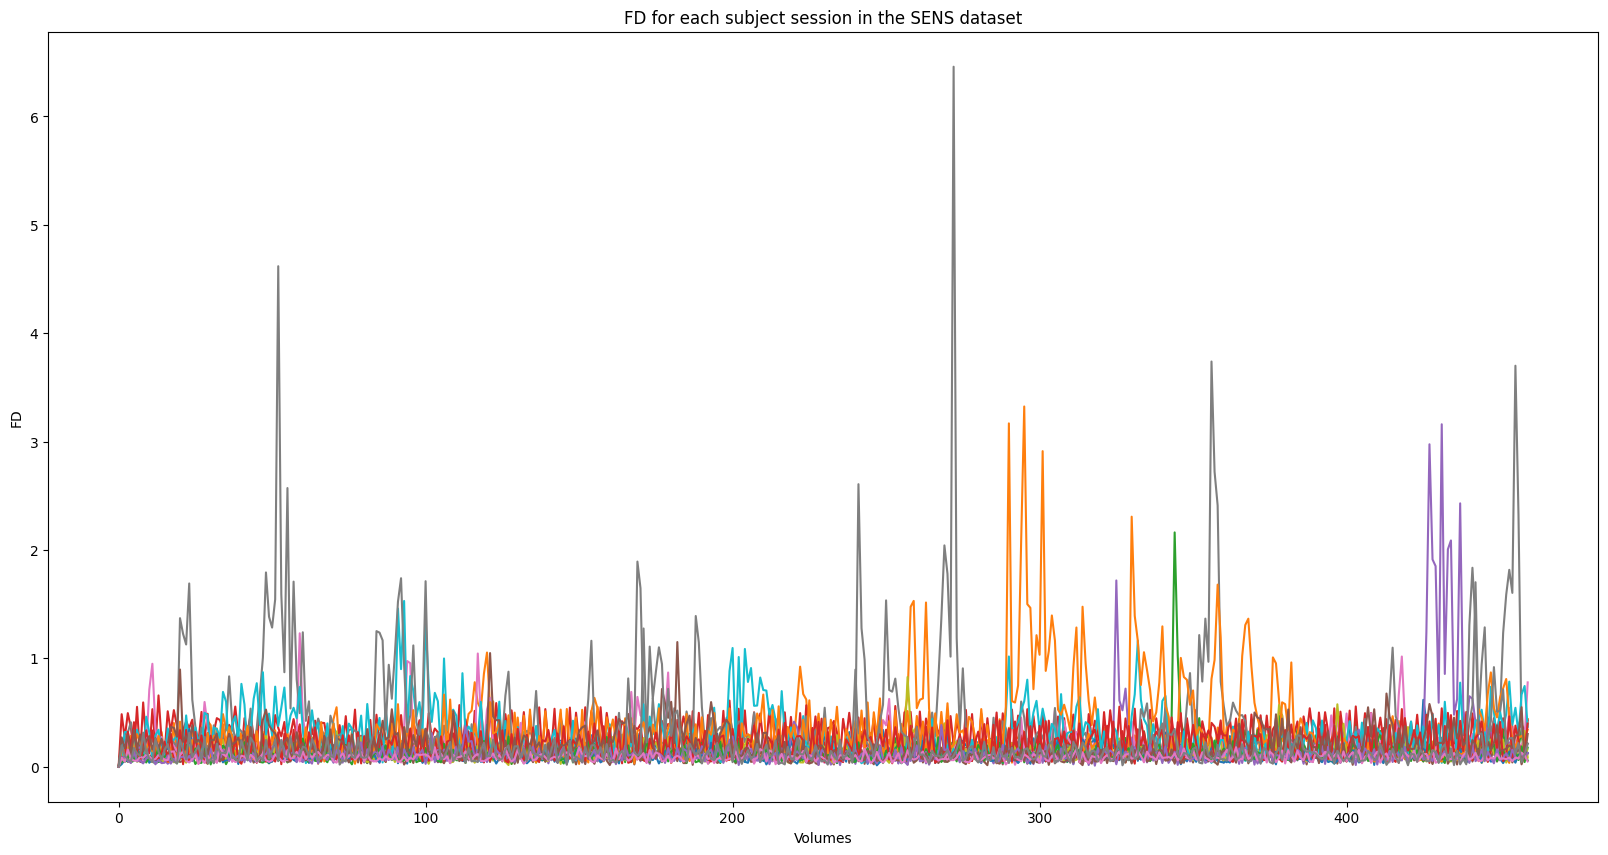

In [19]:
# plot the FD data from df_FD as a line plot 
plt.figure(figsize=(20, 10))
plt.plot(df_FD)
plt.title('FD for each subject session in the SENS dataset')
plt.xlabel('Volumes')
plt.ylabel('FD')
# plt.legend(df_FD.columns)
plt.show()

In [25]:
# show column names of the FD data that have values greater than 4
df_FD_4m_labels = df_FD.columns[df_FD.gt(4).any()]
df_FD_4m_labels


Index(['sub-ID08_task-mem_run-02'], dtype='object')

In [30]:
df_FD_4m_labels = ['sub-ID08_task-mem_run-02']

In [31]:
# get  list
print(df_FD_4m_labels)

['sub-ID08_task-mem_run-02']


In [32]:
# show column values of the columns in df_FD_4m_outliers
df_FD_4m_outliers = df_FD[df_FD_4m_labels]
df_FD_4m_outliers


,sub-ID08_task-mem_run-02
0,0.000000
1,0.214876
2,0.253959
3,0.315495
4,0.410663
...,...
455,3.700150
456,2.323200
457,0.300248
458,0.230910


In [35]:
# compute the mean, median, standard deviation of each column of the df_FD dataframe and save as new columns in the df_FD_stats dataframe
df_FD_stats = pd.DataFrame()
df_FD_stats['mean'] = df_FD.mean(axis=0)
df_FD_stats['median'] = df_FD.median(axis=0)
df_FD_stats['std'] = df_FD.std(axis=0)

# add row labels to the df_FD_stats dataframe from 1 to 54
df_FD_stats.index = range(1, 19)
df_FD_stats


,mean,median,std
1,0.156424,0.145305,0.084133
2,0.245067,0.210303,0.192771
3,0.144279,0.129133,0.131416
4,0.304056,0.287141,0.161303
5,0.174984,0.120601,0.307123
6,0.104397,0.098570,0.054074
7,0.193418,0.149172,0.158340
8,0.400421,0.232094,0.570104
9,0.145028,0.126905,0.090117
10,0.310252,0.272867,0.228247


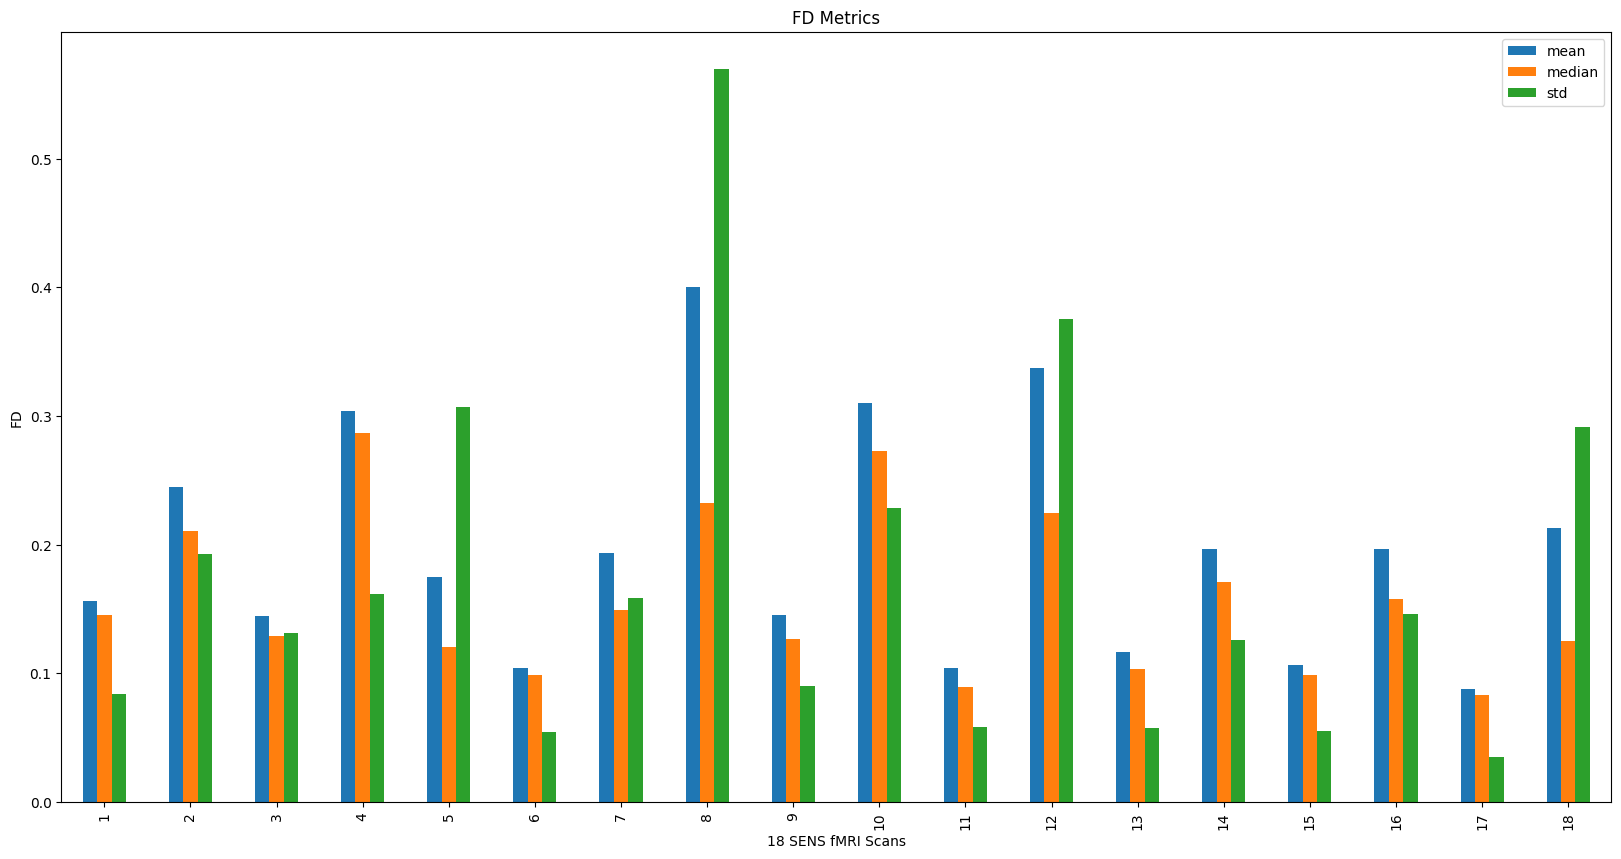

In [36]:
# plot the first column of df_FD_stats as a bar plot
df_FD_stats.plot(kind='bar', figsize=(20, 10))
plt.title('FD Metrics')
plt.xlabel('18 SENS fMRI Scans')
plt.ylabel('FD')
plt.show()


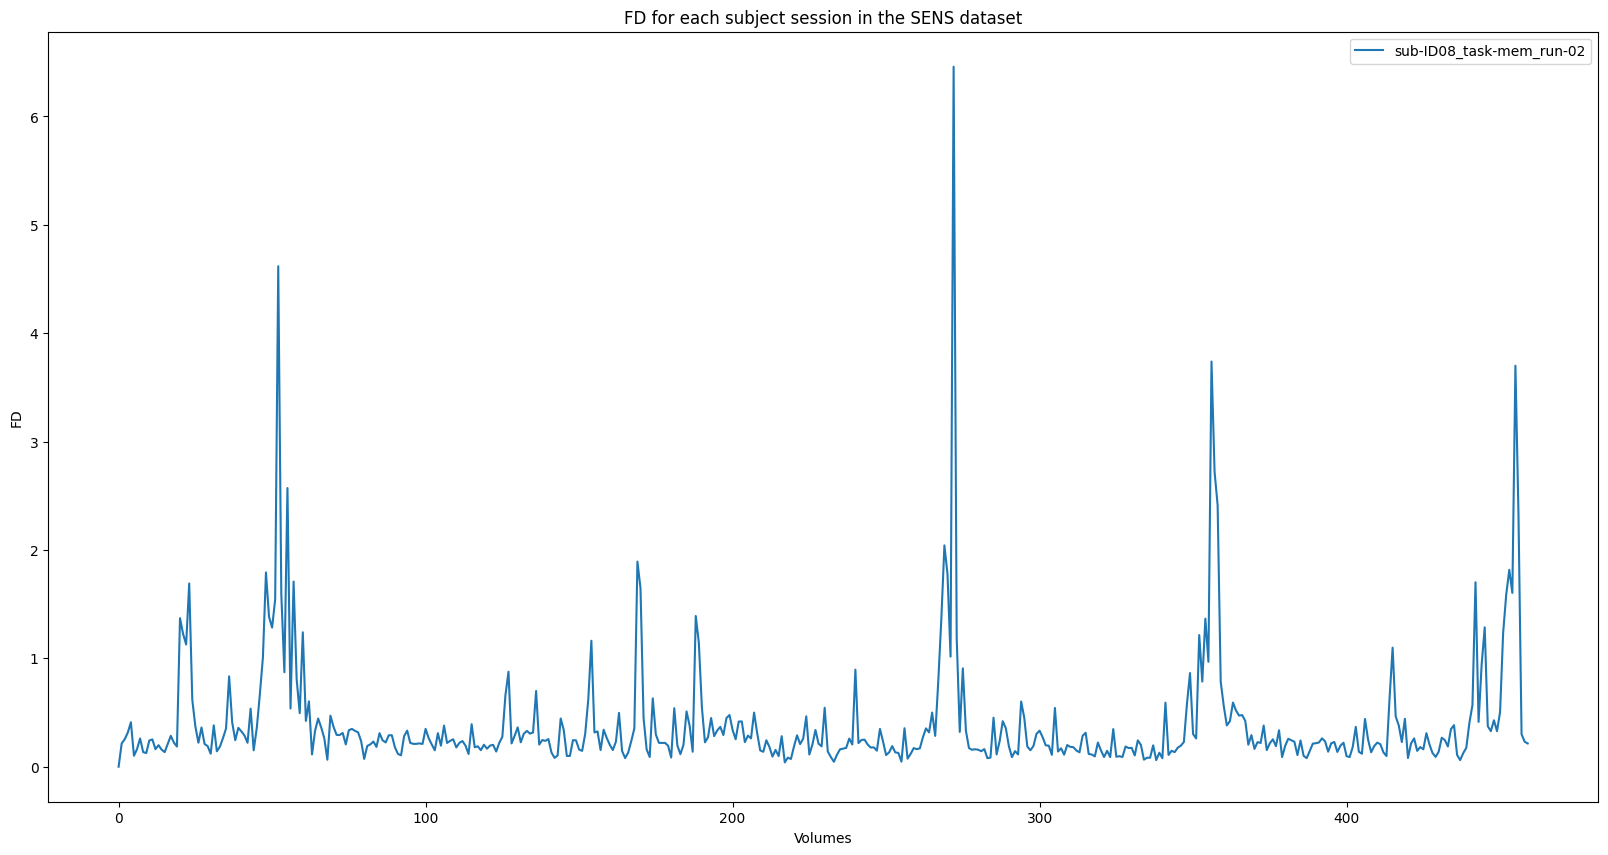

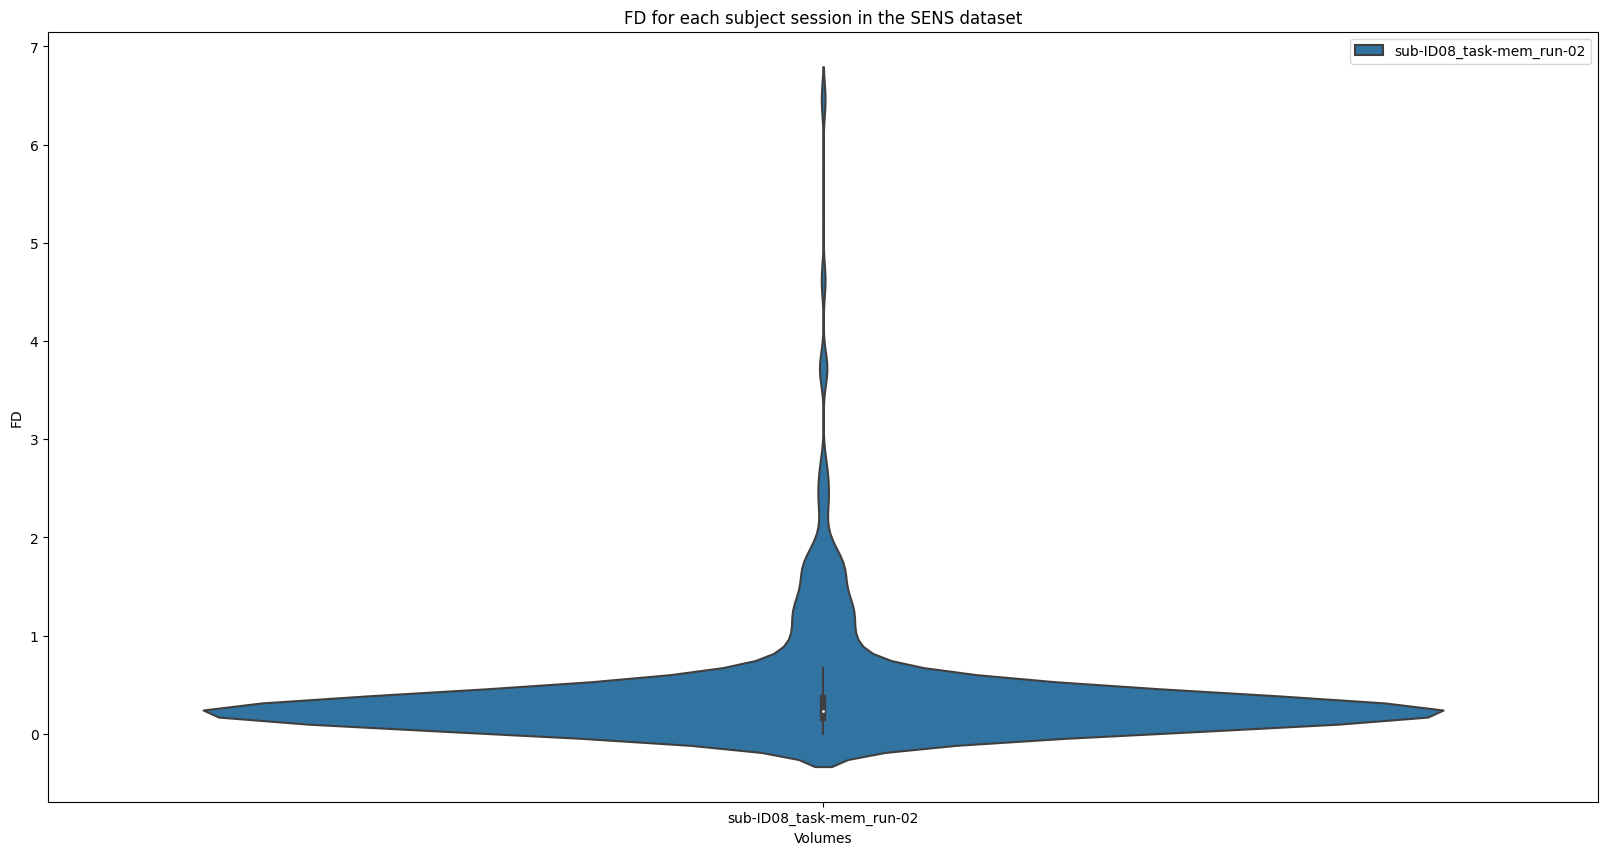

In [39]:
# plot each of the dataframes in df_FD_4m_outliers as a line plot
plt.figure(figsize=(20, 10))
plt.plot(df_FD_4m_outliers)
plt.title('FD for each subject session in the SENS dataset')
plt.xlabel('Volumes')
plt.ylabel('FD')
plt.legend(df_FD_4m_outliers.columns)
plt.show()

# plot the same as violin plots
plt.figure(figsize=(20, 10))
sns.violinplot(data=df_FD_4m_outliers)
plt.title('FD for each subject session in the SENS dataset')
plt.xlabel('Volumes')
plt.ylabel('FD')
plt.legend(df_FD_4m_outliers.columns)
plt.show()

### Scrubbing >2mm FD outliers for >1% of total data points -  (From email 04-08-2024 on MCA analysis)


In [40]:
# get any outliers in the df_FD_4m_outliers for > 2mm
df_FD_2m_labels = df_FD.columns[df_FD.gt(2).any()]
df_FD_2m_labels

Index(['sub-ID06_task-mem_run-01', 'sub-ID07_task-mem_run-01',
       'sub-ID08_task-mem_run-02', 'sub-ID13_task-mem_run-02',
       'sub-ID20_task-mem_run-02'],
      dtype='object')

In [43]:
# find values > 2mm in df_FD_4m_outliers
df_FD_2m_outliers = df_FD_4m_outliers.columns[df_FD_4m_outliers.gt(2).any()]
df_FD_2m_outliers

Index(['sub-ID08_task-mem_run-02'], dtype='object')

In [44]:
df_FD_2m_labels = ['sub-ID08_task-mem_run-02']
df_FD_2m_outliers = df_FD[df_FD_2m_labels]
df_FD_2m_outliers


,sub-ID08_task-mem_run-02
0,0.000000
1,0.214876
2,0.253959
3,0.315495
4,0.410663
...,...
455,3.700150
456,2.323200
457,0.300248
458,0.230910


In [45]:
# binarize the FD data in df_FD_2m_outliers by setting values less than 2 to 1 and values greater than 2 to 0
df_FD_2m_outliers_bin = df_FD_2m_outliers.lt(2).astype(int)
df_FD_2m_outliers_bin

,sub-ID08_task-mem_run-02
0,1
1,1
2,1
3,1
4,1
...,...
455,0
456,0
457,1
458,1


In [47]:
[None]*len(df_FD_2m_labels)

[None]

In [55]:
df_FD_2m_labels[i].split('_')[1] + '_' + df_FD_2m_labels[i].split('_')[2]

'task-mem_run-02'

In [58]:
# get corrected.nii.gz from the path MCA_Mem_path as a list

# forming the scaffold for the SENS data from FD_2m labels
SENS_data = [None] * len(df_FD_2m_labels)
SENS_Scans_FD2mm = [None] * len(df_FD_2m_labels)

for i in range(len(df_FD_2m_labels)):
    SENS_Scans_FD2mm[i] = glob.glob(SENS_path + 'derivatives/' + (df_FD_2m_labels[i]).split('_')[0] + '/func/' + df_FD_2m_labels[i] + '_bold_brain_corrected.nii.gz')

SENS_data.sort()
SENS_data
SENS_Scans_FD2mm.sort()
SENS_Scans_FD2mm

[['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID08/func/sub-ID08_task-mem_run-02_bold_brain_corrected.nii.gz']]

In [63]:
# scrubbing the vols/ tpts from df_FD_2m_labels
from nilearn.image import get_data
import nibabel as nib
for i in range(len(SENS_Scans_FD2mm)):
    SENS_Scan = load_img(SENS_Scans_FD2mm[i])
    print ('Scrubbing:', SENS_Scans_FD2mm[i])
    print('Dimensions of the SENS_Scan:', SENS_Scan.shape)
    print('Original number of volumes:', SENS_Scan.shape[3])
   
    
    SENS_Scan = get_data(SENS_Scan)
    ind_keep = df_FD_2m_outliers_bin.iloc[:, i].astype(bool)
    print('Number of volumes in FD > 2mm:', SENS_Scan.shape[3]-ind_keep.sum())

    # remove all values in ind_keep after MCA_Scan.shape[3]
    ind_keep = ind_keep[:SENS_Scan.shape[3]]
    SENS_Scan_Censored = SENS_Scan[:, :, :, ind_keep]

    SENS_Scan_Scrubbed = new_img_like(SENS_Scans_FD2mm[i], SENS_Scan_Censored)
    SENS_Scan_Scrubbed.to_filename(SENS_Scans_FD2mm[i][0][:-7] + '_scrubbed.nii.gz')

    print('Dimensions of the Scrubbed Data:', SENS_Scan_Scrubbed.shape)
    print('Number of volumes in Scrubbed Data:', SENS_Scan_Censored.shape[3])


Scrubbing: ['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID08/func/sub-ID08_task-mem_run-02_bold_brain_corrected.nii.gz']
Dimensions of the SENS_Scan: (104, 104, 72, 460)
Original number of volumes: 460
Number of volumes in FD > 2mm: 9
Dimensions of the Scrubbed Data: (104, 104, 72, 451)
Number of volumes in Scrubbed Data: 451


## **SENS FIRST LEVEL STATS ANALYSES**

### **1. PRELIM FIRST LEVEL STATS**: With scrubbed fMRI scans from above

Run this script for the **First level subject stats analysis**. This uses the fsf template for including **motion parameters and outliers** to the GLM besides the event information from Memory task.

In [ ]:
!bash /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/Bash_Scripts_Templates/SENS_Mem_firstlevel_PreProStats.sh

### **2. EXTENDED FIRST LEVEL STATS**: Designing extended GLM with additional confounds from CompCor

SENS_MEM_firstlevel_STATSONLY.sh is run after the following steps outlined in the next 7 sections for CompCor data extraction from registered filtered func data.

Preparing the WM, CSF CompCor Eigenseries from FSL FEAT results for a consolidated GLM matrix with new confounds:

In [3]:
MNI_file

'/Users/vogtlab/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

In [19]:
# list all the newest feat folders for SENS First Level Stats

feat_folders = glob.glob(SENS_featpath)
feat_folders.sort()


In [5]:
feat_folders 

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat']

## Get all the needed registration matrices and filtered functional data from Preprocessed Data

In [3]:
# list all the .mat files 
mat_files = glob.glob(SENS_featpath + '/reg/example_func2standard.mat')
mat_files.sort()
mat_files

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/reg/example_func2standard.mat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/reg/example_func2standard.mat']

In [7]:
# list all func files
func_files = glob.glob(SENS_featpath + '/filtered_func_data.nii.gz')
func_files.sort()
func_files

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/filtered_func_data.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/filtered_func_data.nii.gz']

### REG Trial Dataset

In [10]:
mat_files_trial = mat_files[0:2]
mat_files_trial

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_firstlevelstats.feat/reg/example_func2standard.mat']

In [11]:
func_files_trial = func_files[2:4]
func_files_trial


[]

In [19]:
MNI_file

'/Users/vogtlab/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

In [ ]:
# use FSL registration tool for registering the functional images to the MNI space using the .mat transformation matrices
for i in range(len(mat_files_trial)):
    # register the functional images in func_file_trial to the MNI space using the .mat transformation matrices in mat_files_trial
    # print statemennt saying which file is being registered
    print('Registering ' + func_files_trial[i] + ' to MNI space using ' + mat_files_trial[i])
    subprocess.run(['flirt', '-in', func_files_trial[i], '-ref', MNI_file, '-applyxfm', '-init', mat_files_trial[i], '-out', func_files_trial[i].replace('.nii.gz', '_reg.nii.gz')])

## Registration of the filtered func data in each of the feat folders from previously computed transformation matrices

In [9]:
# use FSL registration tool for registering the functional images to the MNI space using the .mat transformation matrices
for i in range(len(feat_folders)):
# for i in range(0, 293): # loop through 292 SENS feat_folders
    # print the file being processed
    print('Checking ' + os.path.basename(feat_folders[i]))

    if exists(func_files[i].replace('.nii.gz', '_reg.nii.gz')):
        print(os.path.basename(feat_folders[i])+ ' registered.')
        continue
    else:
        # register the functional images  to the MNI space using the .mat transformation matrices in reg_mat_files   
        subprocess.run(['flirt', '-in', func_files[i], '-ref', MNI_file, '-applyxfm', '-init', mat_files[i], '-out', func_files[i].replace('.nii.gz', '_reg.nii.gz')])
        # print statemennt saying which file is being registered
        print('Registered ' + func_files[i] + ' to MNI space using ' + mat_files[i])

Checking sub-ID14_task-mem_run-01_08022024_120152.feat
sub-ID14_task-mem_run-01_08022024_120152.feat registered.
Checking sub-ID14_task-mem_run-02_08022024_120152.feat
sub-ID14_task-mem_run-02_08022024_120152.feat registered.
Checking sub-ID17_task-mem_run-01_07292024_175742.feat
sub-ID17_task-mem_run-01_07292024_175742.feat registered.
Checking sub-ID17_task-mem_run-02_07292024_175742.feat
sub-ID17_task-mem_run-02_07292024_175742.feat registered.


In [12]:
# list all the registered functional images in the feat folders
reg_func_files = glob.glob('/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID*/func/sub-ID*_task-mem_run-*_*_*.feat/filtered_func_data_reg.nii.gz')
reg_func_files.sort()
reg_func_files

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/filtered_func_data_reg.nii.gz']

In [11]:
len(reg_func_files) 

4

In [12]:
# check if the legth of the files in reg_mat_files and func_files are the same as the length of the feat_folders
len(mat_files) == len(func_files) == len(feat_folders) == len(reg_func_files)

True

Compute the mean of the registered functional files for underlay

In [12]:
# compute the mean of all the files in reg_func_files
mean_reg_func = mean_img(reg_func_files)
mean_reg_func

In [6]:
# save the mean image as mean_reg_func.nii.gz 
mean_reg_func_file = SENS_path + 'derivatives/interim_files/mean_reg_func_SENS.nii.gz'
# mean_reg_func.to_filename(mean_reg_func_file)


## CompCor Computation

Resampling of the masks are done below. The WM and CSF masks are accessed from the ICBM MNI WM and CSF templates from nilearn repository and resampled to the mean reg functional file from SENS dataset to apply them for 5 CompCor components

In [7]:
# Define the filenames for original and resampled mask file paths for WM and CSF
mask_file_WM = '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/ICBM_templates/mni_icbm152_nlin_sym_09a/mni_icbm152_wm_tal_nlin_sym_09a.nii.gz'
resampled_mask_file_WM = mask_file_WM.replace('.nii.gz', '_SENS_resampled_to_meanfunc_75.nii.gz') # 0.5 thresholding vs 0.99 thresholding vs 0.75 thresholding

mask_file_CSF = '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/ICBM_templates/mni_icbm152_nlin_sym_09a/mni_icbm152_csf_tal_nlin_sym_09a.nii.gz'
resampled_mask_file_CSF = mask_file_CSF.replace('.nii.gz', '_SENS_resampled_to_meanfunc_75.nii.gz')

In [8]:
print(resampled_mask_file_CSF)
print(resampled_mask_file_WM)
print(mean_reg_func_file)

/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/ICBM_templates/mni_icbm152_nlin_sym_09a/mni_icbm152_csf_tal_nlin_sym_09a_SENS_resampled_to_meanfunc_75.nii.gz
/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/ICBM_templates/mni_icbm152_nlin_sym_09a/mni_icbm152_wm_tal_nlin_sym_09a_SENS_resampled_to_meanfunc_75.nii.gz
/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/interim_files/mean_reg_func_SENS.nii.gz


In [9]:
# defining the filename combine the resampled mask images for WM and CSF
combined_mask_file = resampled_mask_file_WM.replace('wm', 'WM+CSF')  
combined_mask_file

'/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/ICBM_templates/mni_icbm152_nlin_sym_09a/mni_icbm152_WM+CSF_tal_nlin_sym_09a_SENS_resampled_to_meanfunc_75.nii.gz'

In [19]:
# load data
img_wm_mask = load_img(mask_file_WM)
img_csf_mask = load_img(mask_file_CSF)

# image operation to combine the resampled mask images for WM and CSF
img_combined_mask = new_img_like(img_wm_mask, img_wm_mask.get_fdata() + img_csf_mask.get_fdata())

# resample the mask to match mean file's resolution/dimensions
img_combined_mask = resample_to_img(img_combined_mask, mean_reg_func_file, interpolation = 'nearest')

# binarise the combined mask image
img_combined_mask = threshold_img(img_combined_mask, threshold=0.75)
img_combined_mask.to_filename(combined_mask_file)


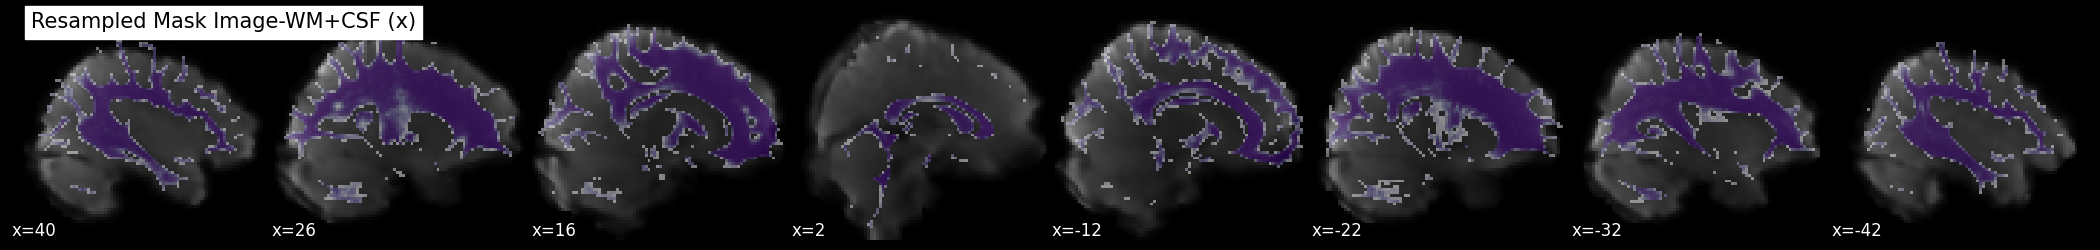

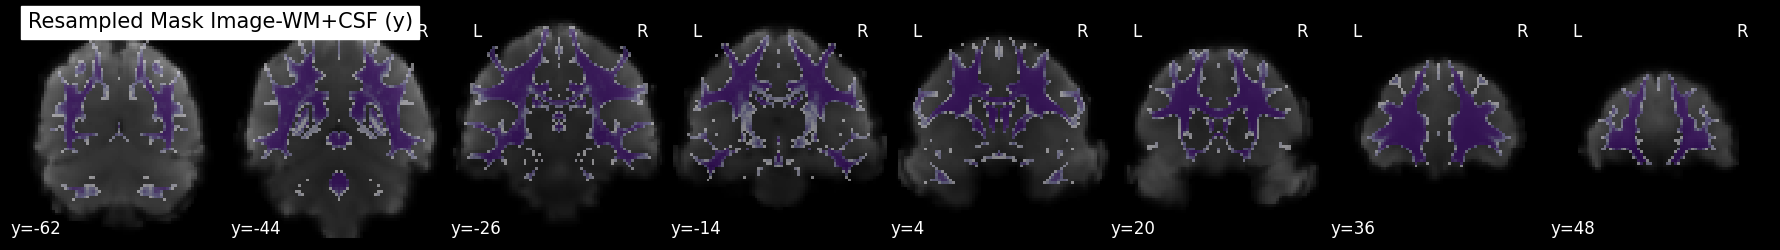

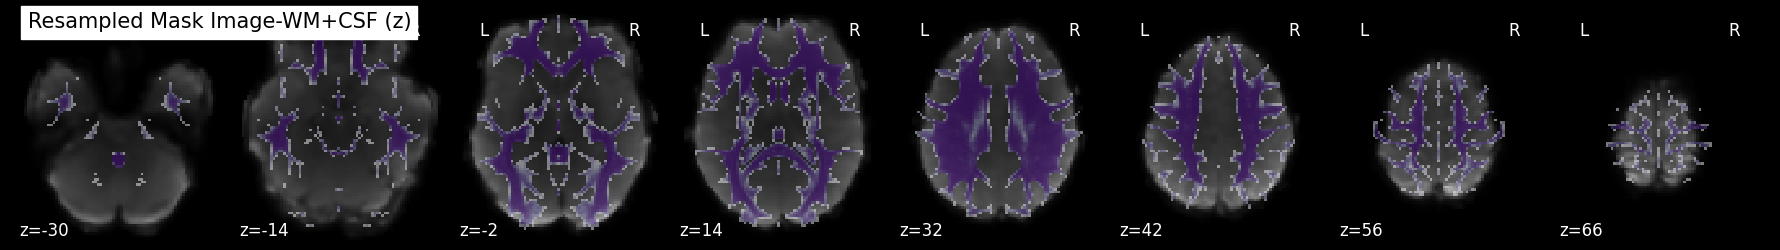

In [20]:
# Computing the WM and CSF masks for trial data from SENS dataset

# Load the example func .nii.gz file for resampling the mask image
in_file =  reg_func_files[0]
img = load_img(in_file)


# plot the resampled mask image on the in_file mean image using nilearn plotting
# mean_reg_sub_file = mean_img(in_file)

# Create a montage of slices in x, y and z directions
for display_mode in ['x', 'y', 'z']:
    # plotting.plot_roi(resampled_mask_file_WM, mean_reg_sub_file, title=f"Resampled Mask Image-WM ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Reds', linewidths=5, alpha=0.5)
    # #savefig(f"Resampled Mask Image-WM ({display_mode}).png")
    # plotting.plot_roi(resampled_mask_file_CSF, mean_reg_sub_file, title=f"Resampled Mask Image-CSF ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Blues', linewidths=5, alpha=0.5)
    #savefig(f"Resampled Mask Image-CSF ({display_mode}).png")
    plotting.plot_roi(combined_mask_file, mean_reg_func_file, title=f"Resampled Mask Image-WM+CSF ({display_mode})", display_mode=display_mode, cut_coords=8, colorbar=False, cmap='Purples', linewidths=5, alpha=0.5) # mean_reg_sub_file for mean of input subjects

plotting.show()


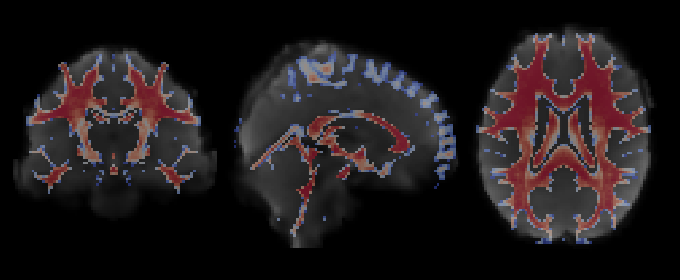

In [21]:
func_underlay = mean_reg_func_file
# plotting "Resampled Mask Image-WM+CSF" on the mean_reg_func image
plotting.plot_roi(combined_mask_file, func_underlay, title=None, display_mode='ortho', colorbar=False, cmap='coolwarm', linewidths=5, alpha=0.5, draw_cross=False, annotate=False, black_bg=True, axes=None)

Function Defined for the CompCor Using FSL ImageMeanTS

In [20]:
reg_func_files

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/filtered_func_data_reg.nii.gz',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/filtered_func_data_reg.nii.gz']

In [25]:
combined_mask_file

'/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/ICBM_templates/mni_icbm152_nlin_sym_09a/mni_icbm152_WM+CSF_tal_nlin_sym_09a_SENS_resampled_to_meanfunc_75.nii.gz'

In [15]:
# Eigen series for all the registered functional images in the feat folders
from nipype.interfaces.fsl.utils import ImageMeants
from nilearn.image import load_img, new_img_like, math_img
n_compcor_components=5

for i in range(len(reg_func_files)):
# for i in range(0, 4):
    ifile = reg_func_files[i]
    ofile = os.path.join(dirname(ifile), basename(ifile).replace('.nii.gz', '_eigen_series_n5_WMCSF_ICBM_MNI.tsv')) # combined mask from WM and CSF
    # print(f'{ofile} is being created..')

    if exists (ofile):
        print(f'Skipping process.. Found existing: {ofile}')
        continue
    else:
        print(f'Processing {ifile}')
        
    # print number of volumes in the file
    img = load_img(ifile)
    print(f'Number of volumes: {img.shape[-1]}')
    
    

    # Type1: FSL from nipype wrapper ImageMeants
    res = ImageMeants(in_file=ifile,
                    mask=combined_mask_file, # can be changed to 0.5 or 0.75 thresholded mask instead of the 0.99 mask
                    out_file=ofile,
                    # nobin=True, # binarinzing the mask
                    order=n_compcor_components,
                    eig=True,
                    show_all=True,
                    terminal_output='stream').run()

    # Type2: Parameters from outside function definition
    # res = ImageMeants()
    # res.inputs.in_file = ifile
    # res.inputs.mask = combined_mask_file
    # res.inputs.out_file = ofile
    # res.inputs.order = n_compcor_components
    # res.inputs.eig = True
    # res.inputs.show_all = True
    # res.cmdline
    # res.run()
    
     
    # show command line in output
    # print('ImageMeants OUTPUTS:')
    print(ofile)



Skipping process.. Found existing: /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv
Skipping process.. Found existing: /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv
Skipping process.. Found existing: /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv
Skipping process.. Found existing: /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv


The CompCor data are stored as FSL compatible .txt format to provide in the GUI for appending to the previously designed GLM matrix for their corresponding functional data.

In [16]:
eigen_series = glob.glob(SENS_featpath + '/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv')    
eigen_series.sort()
eigen_series

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/filtered_func_data_reg_eigen_series_n5_WMCSF_ICBM_MNI.tsv']

## Display/ View CompCor Components as Time Series

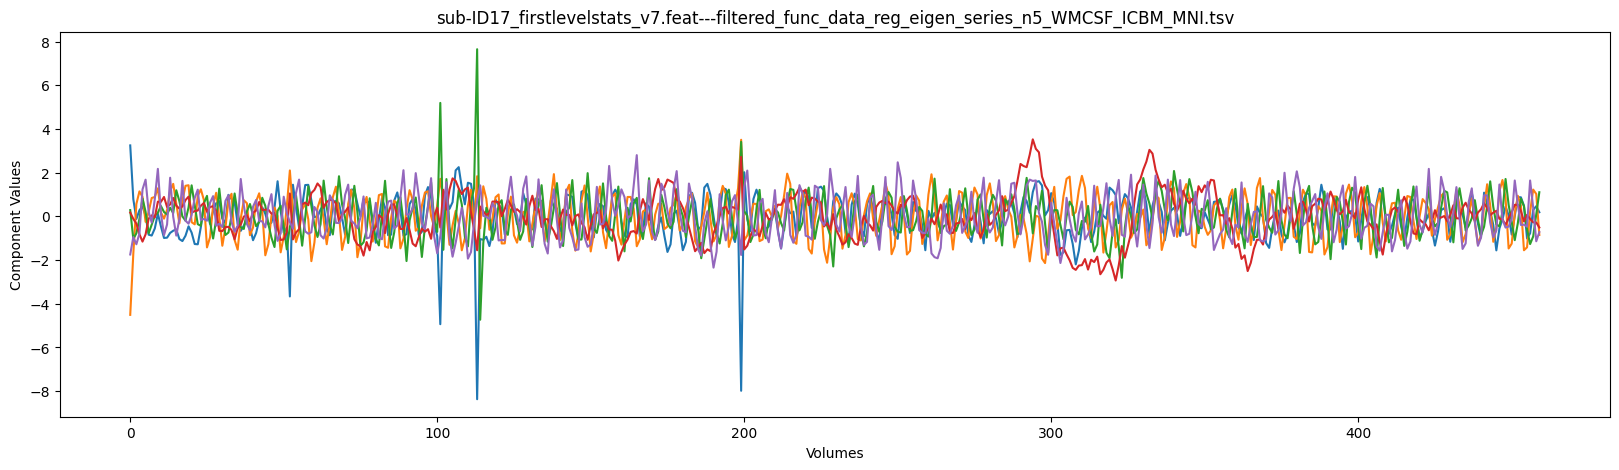

<Figure size 640x480 with 0 Axes>

In [26]:
# plot the combined components of WM and CSF with the corresponding title
for i in range(len(eigen_series)):
    # plot the eigen_series_CSF.tsv files
    plt.figure(figsize=(20, 5))
    plt.plot(np.loadtxt(eigen_series[i]))
    plt.title(os.path.basename(feat_folders[i]) + '---' + os.path.basename(eigen_series[i]))
    plt.xlabel('Volumes')
    plt.ylabel('Component Values')
    # plt.legend()
   
    plt.show()
    # save the plot as a png file in the path NLAcerebropath
    plt.savefig(eigen_series[i].replace('.tsv', '.png'))

## Concatenating GLM Design 
(6 Motion Parameters TSVs,  eigen_series_n*_WMCSF_ICBM_MNI.tsv and motion outlier files)

In [17]:
len(eigen_series)

4

In [21]:
feat_folders

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat']

In [22]:
# get all design.mat files as dataframes and concatenate the eigen_series.tsv files as new columns
for i in range(len(feat_folders)):
# for i in range(0, 1): # trial loop 
    
    matrix_path = feat_folders[i] + '/design.mat'
    df_init = get_design_from_fslmat(matrix_path, column_names=None)   # gets the design matrix from the .mat file as a dataframe
    #print number of columns in the initial design matrix
    print('Number of columns in the initial design matrix: ' + str(df_init.shape[1]) + ' for ' + matrix_path)
    # drop first six columns of the design matrix which are the task timing and derivative for RorK, FGT and SHK; rerunning FEAT sh script will regenerate these columns
    df_init = df_init.drop(df_init.columns[[0, 1, 2, 3, 4, 5]], axis=1) 

    # the new dataframe has only 6 columns:6 Motion Parameters; avoiding a reconcatenation of the motion.par files for the design matrix
    if df_init.shape[1] < 6:
        print('ERROR: Number of columns in the initial Motion Parameter design is not correct for ' + 'matrix_path') 

    # read the combined eigen_series.tsv file
    df_CmCr_n5 = pd.read_csv(eigen_series[i], header=None, sep='  ', engine='python')

    if df_CmCr_n5.shape[1] != 5:
        print('ERROR: Number of columns in the eigen series is not 5 for ' + eigen_series[i])

    #concate the motion parameters and eigen_series_n5 files as columns in a new dataframe
    df_combined_design = pd.concat([df_init, df_CmCr_n5], axis=1)

    # drop any NaN columns in the dataframe
    df_combined_design = df_combined_design.dropna(axis=1)

    # check if the number of rows in the dataframe; i.e.,  volumes in the scan
    nvols = load_img(reg_func_files[i]).shape[3]
    if df_combined_design.shape[0] != 460: #nvols should equal 460 for SENS data
        print('ERROR: Number of rows in the dataframe is not 460 for ' + eigen_series[i])

    # check if the number of columns in the dataframe  i.e. eigen_series_n5 (6 mp + custom confounds from FD+ 5 CompCor)
    # if df_design_n5.shape[1] != 11:
    #     print('ERROR: Number of columns in the dataframe is not 11 for ' + eigen_series_n5[i])   
        
    # save the concatenated files as a txt file for EVs to FSL FEAT
    combined_design = eigen_series[i].replace('_eigen_series_n5_WMCSF_ICBM_MNI.tsv', '_mp6_FD_CmCrn5.txt') # a new filename for n5
    df_combined_design.to_csv(combined_design, index=False, header=False, sep='\t') # save the file as a tab separated txt file
    # print the number of columns in the new design matrix
    print('Number of columns in the combined design matrix: ' + str(df_combined_design.shape[1]) + ' for ' + combined_design)
    print('Saved ' + combined_design)


Number of columns in the initial design matrix: 12 for /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/design.mat
Number of columns in the combined design matrix: 11 for /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg_mp6_FD_CmCrn5.txt
Saved /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg_mp6_FD_CmCrn5.txt
Number of columns in the initial design matrix: 12 for /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/design.mat
Number of columns in the combined design matrix: 11 for /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/filtered_func_data_reg_

Now the TSVs files are consolidated into a single dataframe for each subject which can be fed as a .txt file as for subject level stats with the modified GLM.

In [23]:
SENS_featpath

'/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID*/func/sub-ID*_task-mem_run-*_*_*.feat'

In [24]:
# list all the combined_design files in the NLAcerebropath in ascending order
combined_design_files = glob.glob(SENS_featpath + '/filtered_func_data_reg_mp6_FD_CmCrn5.txt') 
combined_design_files.sort()
combined_design_files

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg_mp6_FD_CmCrn5.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/filtered_func_data_reg_mp6_FD_CmCrn5.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/filtered_func_data_reg_mp6_FD_CmCrn5.txt',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/filtered_func_data_reg_mp6_FD_CmCrn5.txt']

## STATS_ONLY SUBJECT LEVEL RUNS FOR EXTENDED GLM

SENS MEM task runs for subject-level analyses with new combined GLM design are done using **SENS_Mem_firstlevel_STATSONLY.sh**

In [69]:
!bash /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/Bash_Scripts_Templates/SENS_Mem_firstlevel_STATSONLY.sh

Original Data /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/func/sub-ID14_task-mem_run-01_bold.nii.gz found...
Memory Data sub-ID14_task-mem_run-01 already processed with full confounds set. Skipping to next FEAT...
Original Data /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/func/sub-ID14_task-mem_run-02_bold.nii.gz found...
Memory Data sub-ID14_task-mem_run-02 already processed with full confounds set. Skipping to next FEAT...


### MEM STATSONLY REGISTRATION FOR GROUP ANALYSES

For MEM reg and reg_standard folders the foolowing steps are done for avoiding reg errors from FSL.
FSL workaround from MumfordStats: Ref/Source: https://mumfordbrainstats.tumblr.com/post/166054797696/feat-registration-workaround

In [25]:
feat_folders

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat']

In [41]:
SENS_featpath

'/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID*/func/sub-ID*_task-mem_run-*_*_*.feat'

In [39]:
statsonly_folders = glob.glob(SENS_featpath + '/sub-ID*_task-mem_run-*_StatsOnly.feat/')    
statsonly_folders.sort()
statsonly_folders

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/sub-ID14_task-mem_run-01_StatsOnly.feat/',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/sub-ID14_task-mem_run-02_StatsOnly.feat/',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/sub-ID17_task-mem_run-01_StatsOnly.feat/',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/sub-ID17_task-mem_run-02_StatsOnly.feat/']

In [28]:
reg_folders = glob.glob(SENS_featpath + '/reg/')
reg_folders.sort()
reg_folders

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/reg/',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/reg/',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/reg/',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/reg/']

Replacing .mat REG files with identity matrix for avoiding FSL error in higher level runs

In [29]:
# get FSLDIR from environment variables for setting the path to the FSL identity matrix
FSLDIR_path = os.environ['FSLDIR']
identity_matrix = FSLDIR_path + '/etc/flirtsch/ident.mat' 

In [35]:
feat_folders

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat']

In [42]:
if len(reg_folders) == len(statsonly_folders):
    for i in range(len(reg_folders)):
        # check if reg folder ex
        if not exists(statsonly_folders[i] + '/reg'):
            # copy reg folder to stats_only folder
            shutil.copytree(reg_folders[i], statsonly_folders[i] + '/reg')
            print('Copied ' + reg_folders[i] + ' to ' + statsonly_folders[i] + '/reg')
        else:
            shutil.copy(MNI_file, statsonly_folders[i] + '/reg/standard.nii.gz')
            # delete reg_standard folders of exists
            reg_std=statsonly_folders[i]+ 'reg_standard'
            if exists(reg_std):
                shutil.rmtree(reg_std)
                print('Deleted ' + reg_std)
            else:
                print('No ' + reg_std + ' to delete')

            # replace all mat files with identity matrix
            shutil.copy(identity_matrix, statsonly_folders[i] + 'example_func2standard.mat')
            shutil.copy(identity_matrix, statsonly_folders[i] + 'highres2standard.mat')
            shutil.copy(identity_matrix, statsonly_folders[i] + 'example_func2highres.mat')
            shutil.copy(identity_matrix, statsonly_folders[i] + 'highres2example_func.mat')
            shutil.copy(identity_matrix, statsonly_folders[i] + 'standard2example_func.mat')
            shutil.copy(identity_matrix, statsonly_folders[i] + 'standard2highres.mat')

            # print the files that have been replaced
            print('Replaced transformation matrices with identity matrix')
    
    print('All reg folders copied to StatsOnly folders')
else:
    print('Check if the reg folders and StatsOnly folders match')


No /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/sub-ID14_task-mem_run-01_StatsOnly.feat/reg_standard to delete
Replaced transformation matrices with identity matrix
No /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-02_08022024_120152.feat/sub-ID14_task-mem_run-02_StatsOnly.feat/reg_standard to delete
Replaced transformation matrices with identity matrix
No /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-01_07292024_175742.feat/sub-ID17_task-mem_run-01_StatsOnly.feat/reg_standard to delete
Replaced transformation matrices with identity matrix
No /Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID17/func/sub-ID17_task-mem_run-02_07292024_175742.feat/sub-ID17_task-mem_run-02_StatsOnly.feat/reg_standard to delete
Replaced transformation matrices with identity matrix
All 

## GLM Schematic Representation

In [111]:
glm_header_extended ='6 MotionParameters, MotionOutlier(s), 5 White Matter and CSF CompCor'
glm_header_extended

'6 MotionParameters, MotionOutlier(s), 5 White Matter and CSF CompCor'

In [105]:
design_matrix = pd.read_csv('/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/sub-ID14/func/sub-ID14_task-mem_run-01_08022024_120152.feat/filtered_func_data_reg_mp6_FD_CmCrn5.txt', delimiter='\t', engine='python', header=None)
design_matrix

,0,1,2,3,4,5,6,7,8,9,10
0,0.000138,-0.000078,-0.000084,0.014709,-0.010793,-0.015995,4.226522,-1.837567,-1.401492,1.178951,1.062764
1,0.000191,0.000201,0.000219,0.007446,-0.030418,-0.022502,0.991949,0.237380,1.227086,1.778910,0.488122
2,0.000324,0.000135,-0.000036,-0.003137,-0.012199,-0.045386,1.260592,-0.873369,-0.050064,-0.843059,0.103811
3,0.000269,0.000492,0.000083,-0.008193,0.011579,-0.017682,-1.010336,1.296357,-0.685224,1.084547,-0.203002
4,-0.000263,0.000242,-0.000007,-0.013685,0.081042,0.050405,-0.995547,-1.389993,0.767285,0.365324,-0.291338
...,...,...,...,...,...,...,...,...,...,...,...
455,-0.000369,0.000059,0.000081,-0.009050,0.083543,0.066957,-0.607300,-0.437502,-0.673834,1.897666,1.017968
456,-0.000554,-0.000166,0.000074,-0.008030,0.059256,0.061282,-1.102437,-0.925440,0.846443,0.165486,1.761718
457,0.000053,-0.000213,-0.000007,0.005291,-0.014262,-0.000342,0.177311,-0.359953,-0.638030,-1.538592,2.571523
458,0.000338,-0.000040,-0.000013,0.008767,-0.051868,-0.029109,-0.332651,1.534930,-0.597440,-0.119581,2.307453


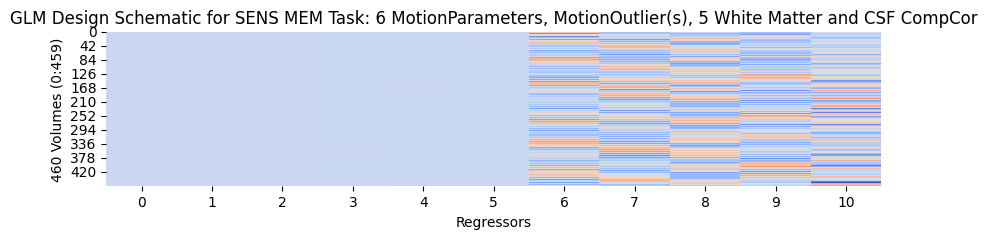

In [118]:
# plot design matrix as a heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(design_matrix, cmap='coolwarm', cbar=False)
plt.xlabel('Regressors')
plt.title('GLM Design Schematic for SENS MEM Task: ' + str(glm_header_extended))
plt.ylabel('460 Volumes (0:459)')
plt.show()

## **SENS GROUP LEVEL ANALYSES**

In [31]:
Group_Level = '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/Group_Analyses/'

In [43]:
# get all directories with the feat directories in Second_Level 
feat_gp_dirs = glob.glob(Group_Level + '/*.gfeat')
feat_gp_dirs.sort()
feat_gp_dirs

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/Group_Analyses/GpAna_N2_ME12_z2_p05_trial.gfeat',
 '/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/Group_Analyses/GpAna_N2_ME12_z2_p05_trial_v2.gfeat']

## **SENS MEM GROUP RESULTS**

In [44]:
# open all report.html files in the FSL_SENS directory
SENS_gp_report_files = glob.glob(Group_Level + '/*.gfeat/cope*.feat/report.html')
SENS_gp_report_files.sort()
SENS_gp_report_files

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/Group_Analyses/GpAna_N2_ME12_z2_p05_trial.gfeat/cope1.feat/report.html']

In [ ]:
# open all report.html files in the SENS_gp_report_files in a new browser window
for SENS_gp_report_file in SENS_gp_report_files:
    subprocess.run(['open', SENS_gp_report_file])


In [49]:
# trial run for extracting labels from the SENS_gp_zstat_files
print(os.path.abspath('/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/Group_Analyses/GpAna_N2_ME12_z2_p05_trial.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[11] + '---' + os.path.abspath('/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/Group_Analyses/GpAna_N2_ME12_z2_p05_trial.gfeat/cope1.feat/rendered_thresh_zstat4.png').split('/')[12])

GpAna_N2_ME12_z2_p05_trial.gfeat---cope1.feat


In [51]:
# make a directory to save the rendered_thresh_zstat*.png files in the FSL_Pain directory as a PPT file
SENS_gp_fig = Group_Level + '/SENS_GP_FIGURES/nilearn_PNGs'
os.makedirs(SENS_gp_fig, exist_ok=True)


In [52]:
savepath=Group_Level + '/SENS_GP_FIGURES/nilearn_PNGs/' # nilearn_PNGs or MRIcroGL_PNGs
MNI_filefor_PNGs='/Volumes/MRIcroGL/MRIcroGL.app/Contents/Resources/standard/mni152.nii.gz'

In [64]:
SENS_gp_thresh_zstats = glob.glob(Group_Level + '/*v2.gfeat/cope*.feat/thresh_zstat1.nii.gz') 
SENS_gp_thresh_zstats.sort()
SENS_gp_thresh_zstats

['/Volumes/cerebro/Studies/VOGT/SENS/Public/Data/SENS_BIDS/derivatives/Group_Analyses/GpAna_N2_ME12_z2_p05_trial_v2.gfeat/cope1.feat/thresh_zstat1.nii.gz']

In [68]:
# load the zstat files from MEM_Third_Level_Stat_Files
for SENS_gp_thresh_zstat in SENS_gp_thresh_zstats:
    # title = (os.path.abspath(SENS_gp_thresh_zstat).split('/')[10]).replace('.gfeat', '') + '---' + os.path.abspath(SENS_gp_thresh_zstat).split('/')[11].replace('.nii.gz', '')
    title = (os.path.abspath(SENS_gp_thresh_zstat).split('/')[10]).replace('.gfeat', '')  + '---Low_Dose_Average'
    cmap_choice = 'hot'
    
    # # if title contains Neg, set the cmap to Blues else set it to hot
    # if 'Neg' in title:
    #     cmap_choice = 'Blues'
    # else:
    #     cmap_choice = 'hot'

    # #FIG 1
    # # plot the zstat file; Set vmin and vmax to the minimum and maximum values of the zstat file; edit to 2-8 if necessary
    # display1 = plot_stat_map(SENS_gp_thresh_zstat, display_mode="mosaic", black_bg=False, colorbar=True, threshold=2, draw_cross=False, bg_img=MNI_filefor_PNGs, annotate=False, cmap='hot')
    # display1.title((title), size=8)
    # display1.annotate(size=8)
    # display1.savefig(savepath+title+str('_mosaic.png'))
    # plt.show()

    # #FIG 2
    # display2 = plot_stat_map(SENS_gp_thresh_zstat, display_mode='tiled', black_bg=False, colorbar=True, threshold=2, vmin=None, vmax=8, draw_cross=False, annotate=False, bg_img=MNI_filefor_PNGs, cmap='hot')
    # display2.title((title), size=8)
    # display2.annotate(size=8)
    # display2.savefig(savepath+title+str('_tiled.png'))
    # plt.show()

    # #FIG 3
    # display3 = plot_glass_brain(SENS_gp_thresh_zstat, display_mode='lyrz', black_bg=False, title=title, colorbar=True, threshold=2, vmin=None, vmax=8, draw_cross=False, annotate=True, bg_img=MNI_filefor_PNGs)
    # display3.savefig(savepath+title+str('_glass.png'))
    # plt.show()

    # #FIG 4
    # plot_img_on_surf(SENS_gp_thresh_zstat, surf_mesh='fsaverage', hemispheres=['left', 'right'], threshold=2, colorbar=True, title=title, cmap='hot', title_font_size=8, output_file=savepath+title+str('_surf.png'))
    # plt.show()

    # #FIG 5
    plot_img_on_surf(SENS_gp_thresh_zstat, surf_mesh='fsaverage', hemispheres=['left', 'right'], inflate=True, threshold=None, colorbar=True, title=title, cmap=cmap_choice, title_font_size=8, output_file=savepath+title+str('_surf_inflate.png'))
    plt.show()
    
    #FIG 6 : axial slice set from -24 to 50 
    # display4 = plot_stat_map(SENS_gp_thresh_zstat, display_mode="z", cut_coords=[-24, -20, -16, -10, 0, 10, 20, 30, 40 ,50], black_bg=False, colorbar=True, draw_cross=False, bg_img=MNI_filefor_PNGs, annotate=False, cmap=cmap_choice)

    # display4.title((title), size=8)
    # display4.annotate(size=8)
    # display4.savefig(savepath+title+str('_axial.png'))
    # plt.show()